# Required Libraries

In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We used matplotlib to visualize the training and test data, numpy to perform numerical operations, pandas for data manipulation and, tensorflow to build and train the model, and PIL to load and preprocess the images.

In [2]:
## Lucas's Directory
# data_dir_train = '/Users/lucashawranke/downloads/birds/data/train/15'
# data_dir_valid = '/Users/lucashawranke/downloads/birds/data/valid/15'
# data_dir_test = '/Users/lucashawranke/downloads/birds/data/test/15'

In [3]:
# Mahyar's directory
data_dir_train = 'archive/train/15'
data_dir_valid = 'archive/valid/15'
data_dir_test = 'archive/test/15'

In [4]:
# Defining variables
batch_size = 10
img_height = 150
img_width = 150
epochs = 40

We went with a batch size of 10 as a good middle ground of speed and accuracy. The image dimensions of 150x150 work well for computational speed and accuracy. The number of epochs was chosen to have the model learn as much information from the training data as possible.

# Datasets

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2419 files belonging to 15 classes.


In [6]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_valid,
  label_mode='categorical',
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75 files belonging to 15 classes.


In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode='categorical',
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75 files belonging to 15 classes.


### We are covering the first 15 classes of birds, here are the names of them:

In [8]:
class_names = train_ds.class_names
print(class_names)

['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN']


# Visualize  the data

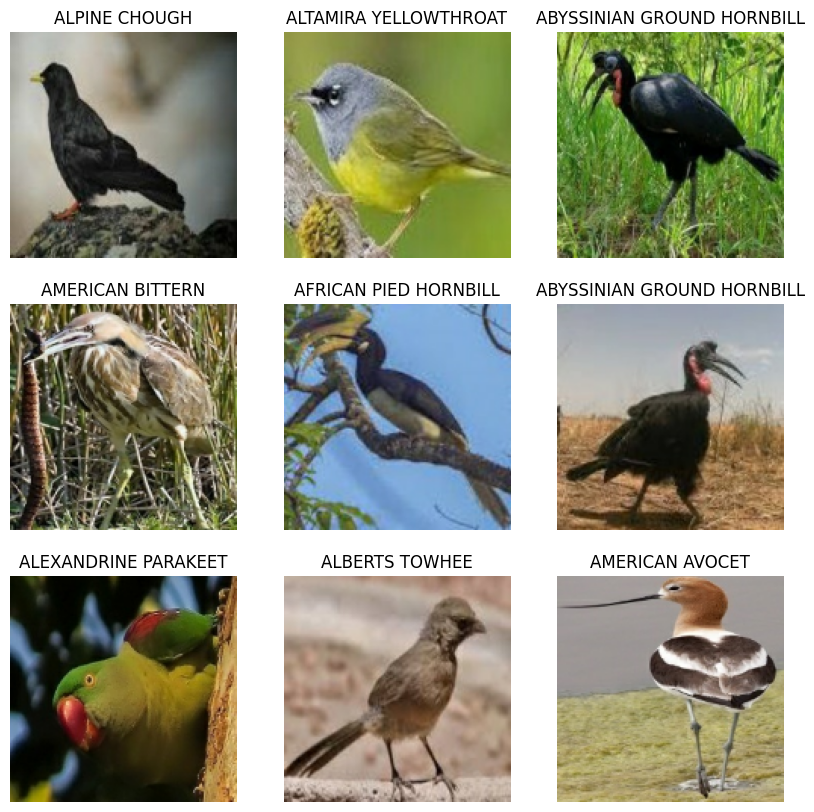

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

### Early Stop

In [10]:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Modelling

To handle overfitting, we used two techniques: 
#### Data augmentation 
Data augmentation generates additional data from current train dataset and applies some rotation/zooming to help the model have a better performance.
#### Dropout
Dropouts remove a percentage of the outputs of the last layer. In our case, we are removing 50 percent of outputs of the second hidden layer each iteration which leads to reduce the overfitting.

#### Softmax
For the multi-class classification problem, it's recomended to use softmax as an activation function on the last layer. Softmax assigns decimal probabilities to each category in the problem. These probabilities must add up to 1.0. 

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [12]:
num_classes = len(class_names)

model = Sequential([
  # Without Data augmentation  
  #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  # With Data augmentation  
  data_augmentation,
  layers.Rescaling(1./255),
  
  #First Hidden Layer 
  layers.Conv2D(32, 3,  activation='relu'),
  layers.MaxPooling2D(),
  
  #Second Hidden Layer
  layers.Conv2D(16, 3,  activation='relu'),
  layers.MaxPooling2D(),
    
  #Third Hidden Layer  
  #layers.Conv2D(64, 3,  activation='relu'),
  #layers.MaxPooling2D(),
    
  #Drop Out
  layers.Dropout(0.5),
  layers.Flatten(),
    
  layers.Dense(64, activation='relu'),
  layers.Dense(units=num_classes, activation='softmax')
])

 Here, we have 3 hidden layers. The first 2 have 32 nodes and the third has 16 nodes. We use a "relu" activation function on the first 3 layers. We use a "softmax" activation function on the output layer because this is a multi-class classification problem. We use a "dropout" of 0.5 on the input layer to help prevent overfitting.

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 16)       0         
 2D)                                                  

# Compiling and fitting

Beacause we are dealing with multiple categorical data, it is better to use [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) as a loss function and Adam as the optimizer.


In [14]:
model.compile(optimizer='adam', 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(train_ds, validation_data= valid_ds, epochs =epochs, callbacks =[callback]);

Epoch 1/40
242/242 [==============================] - 14s 51ms/step - loss: 2.3999 - accuracy: 0.1931 - val_loss: 1.7435 - val_accuracy: 0.4667
Epoch 2/40
242/242 [==============================] - 12s 49ms/step - loss: 1.6651 - accuracy: 0.4415 - val_loss: 1.4021 - val_accuracy: 0.5200
Epoch 3/40
242/242 [==============================] - 12s 49ms/step - loss: 1.4325 - accuracy: 0.5291 - val_loss: 1.1409 - val_accuracy: 0.6533
Epoch 4/40
242/242 [==============================] - 12s 48ms/step - loss: 1.2495 - accuracy: 0.5730 - val_loss: 1.0439 - val_accuracy: 0.6800
Epoch 5/40
242/242 [==============================] - 12s 50ms/step - loss: 1.1247 - accuracy: 0.6313 - val_loss: 0.8786 - val_accuracy: 0.7333
Epoch 6/40
242/242 [==============================] - 12s 48ms/step - loss: 1.0482 - accuracy: 0.6527 - val_loss: 0.7667 - val_accuracy: 0.7067
Epoch 7/40
242/242 [==============================] - 12s 48ms/step - loss: 1.0032 - accuracy: 0.6759 - val_loss: 0.7291 - val_accuracy:

# Our Best Model
We were able to make a model and train it to 82 percent accuracy. The model is saved as "model82.h5". Please load the model to see the accuracy and prediction on new data.

In [1]:
# # save model and architecture to single file
# model.save("model82.h5")
# print("Saved model to disk")

In [11]:
## Load the model 
from tensorflow.keras.models import load_model
model = load_model('model/model82.h5')

# Predict on new data

These are the pictures we picked randomly from test data set.


![](assets/test_birds.jpg)

Our model is capable of predicting the first three birds. The last one is really hard to interpret even for humans. The details of the bird are not as clear as the other three. Therefore, our model is not able to predict it correctly.

In [12]:
#pic = 'AFRICAN_CROWNED_CRANE'
#pic = 'AFRICAN_FIREFINCH'
pic = 'AFRICAN_PIED_HORNBILL'
#pic = 'ALPINE_CHOUGH'

In [13]:
import numpy as np
from keras.utils import load_img, img_to_array
#test_image = load_img(f'/Users/lucashawranke/Downloads/birds/data/images_to_test/{pic}.jpg', target_size = (img_height, img_width))
test_image = load_img(f'archive/images_to_test/{pic}.jpg', target_size = (img_height, img_width))

test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
predictions = model.predict(test_image)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 197ms/step
This image most likely belongs to AFRICAN PIED HORNBILL with a 16.15 percent confidence.


This code the image from the folder we created and converts it to an array. Then, we predit the class of the bird in the image. The softmax function returns the probability of each class. We then print the most likely class the model predicts.

# Classification Evaluation 

In [14]:
# Evaluation on test 
model.evaluate(test_ds);

8/8 [==============================] - 1s 52ms/step - loss: 0.8549 - accuracy: 0.8267


In [15]:
# Calculating prediction and ground truth on Test dataset
y_true = []
for t, tensor in test_ds.unbatch().enumerate():
    array = tensor[1].numpy()
    y_true.append(array.argmax(axis=0))

y_predict = model.predict(test_ds).argmax(axis=1)

# Confusion Matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_true, y_predict)
print(cm,'\n')
accuracy_score(y_true, y_predict)

# Precision and recall
from sklearn.metrics import classification_report
print(classification_report(y_true,y_predict)) 

8/8 [==============================] - 1s 51ms/step
[[2 0 0 0 0 1 0 0 0 1 0 0 0 0 1]
 [0 4 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 3 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 3 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 3]] 

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.80      0.80      0.80         5
           2       0.75      0.60      0.67         5
           3       0.71      1.00      0.83         5
           4       0.71      1.00      0.83         5
           5       0.83      1.00      0.91         5
           6       0.83      1.00      0.91         5
           7     

Let's compare two classes (0 ,10) with lowest(0.57) and highest(1.00) f1-score

![](assets/conf_matrix_birds.jpg)

If we look at The bird on class 0, there are not much specific details that make this species be recognizble. On the other hand, the bird on class 10 which is a parrot breed is fully recognizable even for human.

# Visualizing model's performance

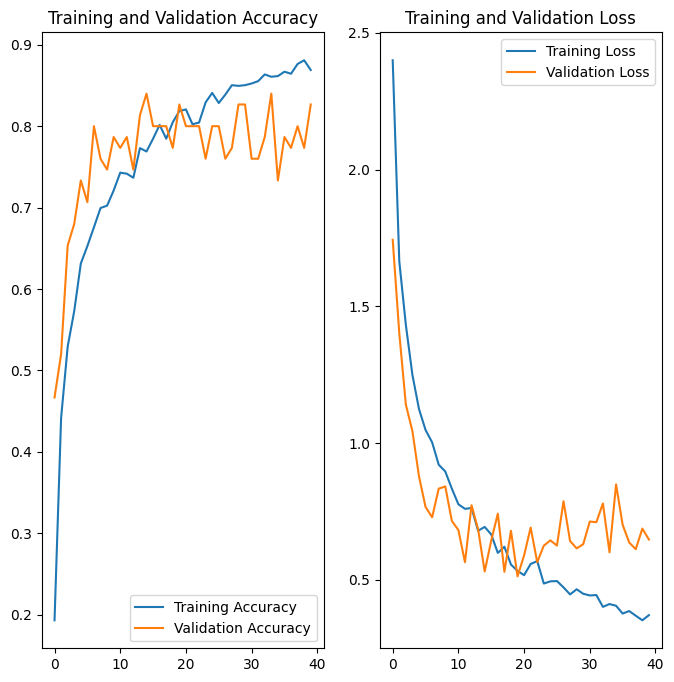

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, accuracy, label='Training Accuracy')
plt.plot(epoch_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


![](assets/model_visualize.jpg)

In the plot above, we can see that during all epochs, the greatest accuracy is around 85 percent which is not far from our last result.

# Conclusion

In conclusion, we have built a model to classify birds in images. The model has an accuracy rate of 82% on the test dataset. This is a good model for this problem. If we wanted to improve the model, we could use a larger training dataset, more data augmentation, or more hidden layers.

These are the hyperparameters that we tuned to get a 82 percent accuracy with the test dataset:

- Batch size<br>
- Epochs<br>
- Number of hidden layers<br>
- Number of neurons in each hidden layer<br>
- Number of neurons in last dense layer<br>
- Dropout percentage<br>
- Adding data augmentation<br>

Finding the best parameter to tune the CNN model is a time consuming process. 
By adding more images in the dataset, we might get a better result.